In [1]:
# Enable autoreload of libraries on execution
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tqdm import tqdm

# Dataset Exploration


In [2]:
dataset_path = r"G:\VM\Shared Folder\bags\0001.bag"
EVENTS_TOPIC = "/cam0/events"
IMAGES_TOPIC = "/cam0/image_raw"

# dataset_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_jenga_destroy.bag"
# EVENTS_TOPIC = "/dvs/events"
# IMAGES_TOPIC = "/dvs/image_color"

## Dataset Inspection


### Inspect messages content


In [ ]:
from dataset_utils import inspect_bag
inspect_bag(dataset_path)

##### **Image events content:**

**data**: binary image data encoded according to encoding

**encoding**: format used to encode the image data - e.g. mono8, bgr8

**width**, **height**: size of the image

**is_bigendian**: endianness of image

**step**: full row length in bytes

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Event events content:**

**events**: array of events

**width**, **height**: size of the camera sensor

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Events format:**

**x**, **y**: coordinates of the pixel sensor

**polarity**: polarity of the event in {True, False}

**ts**:

-   **secs**: seconds since epoch
-   **nsecs**: nanoseconds since ts.secs


### Inspect message timestamps


In [ ]:
from dataset_utils import inspect_message_timestamps
inspect_message_timestamps(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC)


The events are not completely sequential, since there can be two image events after each other (e.g. 6-7) but the first event timestamp of the next event is before the last image (e.g 8).

Moreover, there are some events that are acquired after the last image has been captured.


## Dataset Analysis

### Dataset Loading

In [ ]:
from dataset_utils import load_bag_as_dataframes
events_df, images_df = load_bag_as_dataframes(dataset_path, events_topic=EVENTS_TOPIC, images_topic=IMAGES_TOPIC, max_events=1e6)
print("Events dataframe")
display(events_df)
print("Images dataframe")
display(images_df)


Events and frames are already ordered by timestamp, since they are produced from a real simulation.


### Number of events per image frame

Check how many events there are among each image frame.

This roughly reflects the amount of movement in the sequence.


In [ ]:
from dataset_utils import plot_number_of_events_per_frame
plot_number_of_events_per_frame(events_df, images_df)

### Check image frames frequency


In [ ]:
from dataset_utils import plot_image_frames_frequency
plot_image_frames_frequency(images_df)

### Save events for visualization


In [ ]:
from media_utils import save_visual_bayer_events, save_visual_accumulated_events

w, h = images_df.iloc[0].width, images_df.iloc[0].height
folder_name = os.path.basename(dataset_path).replace(".bag", "")
output_dir = os.path.join(os.path.dirname(dataset_path), folder_name)
save_visual_bayer_events(events_df, w, h, os.path.join(output_dir, "visual_events"))
save_visual_accumulated_events(events_df, w, h, os.path.join(output_dir, "visual_images"))

# Metadata parsing (old logs)

In [ ]:
import json

metadata_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\05 - Experiments\2022-08-31 15-36-51\metadata.json"
with open(metadata_path, encoding="utf8") as f:
    data = json.load(f)

In [ ]:
import matplotlib.pyplot as plt

print("Number of epochs:", len(data["epochs"]))
train_loss = [epoch["train_loss"] for epoch in data["epochs"]]
valid_loss = [epoch["valid_loss"] for epoch in data["epochs"]]
plt.plot(range(len(data["epochs"])), train_loss, color="blue", label="Training Loss")
plt.plot(range(len(data["epochs"])), valid_loss, color="orange", label="Valid loss")
plt.legend()
plt.show()

In [ ]:
from dataset_utils import dataset_generator_from_bag, save_events_frames_view
# path = r"G:\CED Datasets\simple_color_keyboard_2.bag"
# gen = dataset_generator_from_bag(path, "/dvs/events", "/dvs/image_color", min_n_events=10000, crop_size=(128, 128))
path = r"G:\VM\Shared Folder\bags\DIV2K_0.5\0804.bag"
gen = dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw", crop_size=(128, 128))
save_events_frames_view("signore.mp4", gen, model=model, denorm=True)

# Tests

## RAM Image Callback Test

In [ ]:
import pytorch_lightning as pl
import torch

from utils import KerasProgressBar, LogImagesCallback

class UselessModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.param = torch.nn.parameter.Parameter(torch.tensor(0, dtype=torch.float32))

    def forward(self, x):
        return self.param

    def training_step(self, train_batch, batch_idx):
        return np.random.rand() - self.param

    def validation_step(self, val_batch, batch_idx):
        return np.random.rand() - self.param
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


model = UselessModel()

callbacks = []
train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
callbacks.append(LogImagesCallback(train_batch, valid_batch, n=5, n_epochs=1))
callbacks.append(KerasProgressBar())

logger = pl.loggers.TensorBoardLogger(experiments_dir, "test CB")
log_every = 50
if len(train_dataloader) < log_every:
    log_every = 1

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, accelerator="gpu", logger=logger, log_every_n_steps=log_every, enable_progress_bar=True)
trainer.fit(model, train_dataloader, valid_dataloader)

## LPIPS Test

In [ ]:
from torchvision.models import vgg19, VGG19_Weights
from scipy.ndimage import gaussian_filter
from torch.nn.functional import mse_loss
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import torch

features_outputs = []

img_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_color_keyboard_1\color_images\0.png"
img2_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_color_keyboard_1\color_images\130.png"
img3_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_fruit\color_images\0.png"
img = plt.imread(img_path)[:,:,:3]
img_noise = img * np.random.rand(*img.shape)
img_blur = gaussian_filter(img, sigma=(5, 5, 0))
img2 = plt.imread(img2_path)[:,:,:3]
img3 = plt.imread(img3_path)[:,:,:3]

plt.figure(figsize=(10, 5))
plt.imshow(np.hstack((img, img_noise, img_blur, img2, img3)))
plt.show()

img = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0)
img_noise = torch.Tensor(img_noise).permute(2, 0, 1).unsqueeze(0)
img_blur = torch.Tensor(img_blur).permute(2, 0, 1).unsqueeze(0)
img2 = torch.Tensor(img2).permute(2, 0, 1).unsqueeze(0)
img3 = torch.Tensor(img3).permute(2, 0, 1).unsqueeze(0)

vgg_weights = VGG19_Weights.IMAGENET1K_V1
vgg = vgg19(weights=vgg_weights)
vgg.eval()
vgg_preprocess = vgg_weights.transforms()

# train_nodes, eval_nodes = get_graph_node_names(vgg)
# print(train_nodes)

VGG_LAYER = "features.35"
vgg_extractor = create_feature_extractor(vgg, [VGG_LAYER])

features_img = vgg_extractor(vgg_preprocess(img))[VGG_LAYER]
features_noise = vgg_extractor(vgg_preprocess(img_noise))[VGG_LAYER]
features_blur = vgg_extractor(vgg_preprocess(img_blur))[VGG_LAYER]
features_img2 = vgg_extractor(vgg_preprocess(img2))[VGG_LAYER]
features_img3 = vgg_extractor(vgg_preprocess(img3))[VGG_LAYER]

mse_noise = mse_loss(img, img_noise)
mse_blur = mse_loss(img, img_blur)
mse_same = mse_loss(img, img)
mse_img2 = mse_loss(img, img2)
mse_img3 = mse_loss(img, img3)

print(f"{'MSE:':10}  same - {mse_same:.4f}, noise - {mse_noise:.4f}, blur - {mse_blur:.4f}, img2 - {mse_img2:.4f}, img3 - {mse_img3:.4f}")

mse_features_noise = mse_loss(features_img, features_noise)
mse_features_blur = mse_loss(features_img, features_blur)
mse_features_same = mse_loss(features_img, features_img)
mse_features_img2 = mse_loss(features_img, features_img2)
mse_features_img3 = mse_loss(features_img, features_img3)

print(f"{'LPIPS:':10}  same - {mse_features_same:.4f}, noise - {mse_features_noise:.4f}, blur - {mse_features_blur:.4f}, img2 - {mse_features_img2:.4f}, img3 - {mse_features_img3:.4f}")



## Binary File Reading

In [ ]:
from dataset_utils import dataset_generator_from_bag, dataset_generator_from_binary, save_samples_to_disk
import time
import torch
import numpy as np

bag_file_path = r"G:\VM\Shared Folder\bags\COCO\000000000139.bag"
bin_file_path = r"G:\VM\Shared Folder\bags\COCO\000000000139.bin"


bag_gen = dataset_generator_from_bag(bag_file_path, events_topic="/cam0/events", image_topic="/cam0/image_raw")
save_samples_to_disk(bag_gen, "test_bag_batches", False)
bag_gen = dataset_generator_from_bag(bag_file_path, events_topic="/cam0/events", image_topic="/cam0/image_raw")
save_samples_to_disk(bag_gen, "test_bag_batches_compressed", True)
bin_gen = dataset_generator_from_binary(bin_file_path)
save_samples_to_disk(bin_gen, "test_bin_batches", False)
bin_gen = dataset_generator_from_binary(bin_file_path)
save_samples_to_disk(bin_gen, "test_bin_batches_compressed", True)

for i, (bagf, binf) in enumerate(zip(bag_gen, bin_gen)):
    events_equal = np.array_equal(bagf[0], binf[0])
    img_equal = np.array_equal(bagf[1], binf[1])
    print(events_equal, img_equal)

## Colors channeling (scrapped for now)

In [ ]:
import numpy as np
import torch

batch = 2
bins = 2
w = 16
h = 16

x = torch.arange(0, batch*bins*w*h) + 1
x = x.reshape(batch, bins, h, w)

# x = x.reshape(batch, bins, h // 4, w // 4, 2, 2, 2, 2)

r = x[:, :, ::2, ::2]
g = x[:, :, ::2, 1::2]
G = x[:, :, 1::2, ::2]
b = x[:, :, 1::2, 1::2]
x = torch.stack((r,g,G,b), dim=2).squeeze()
print(x.shape, x)

# x = x.transpose(4, 5)
# x = x.transpose(5, 7)

# x = x.reshape(batch, bins, 4, h // 2, w // 2)
# x = x.permute(0, 1, 5, 3, 2, 4)

## Dataset events values range

In [8]:
from dataset import DIV2KDataset

DIV2K_DATASET_PATH = r"C:\datasets\DIV2K_5_fix"
datasets = ["{:04}".format(i) for i in range(1, 900 + 1)]

mins = []
maxs = []
for dataset in datasets:
    d = DIV2KDataset(DIV2K_DATASET_PATH, sequences=[dataset], crop_size=(128, 128), preload_to_RAM=True, normalize_events=True)
    v_min, v_max = None, None
    for events, img in d:
        d_min, d_max = events.min(), events.max()
        if v_min is None or d_min < v_min:
            v_min = d_min
        if v_max is None or d_max > v_max:
            v_max = d_max
    mins.append(d_min)
    maxs.append(d_max)

print(min(mins), max(maxs))

-0.11908084 0.118364096


## Events integration colors

Warning, there are no events between two frames, skipping one.


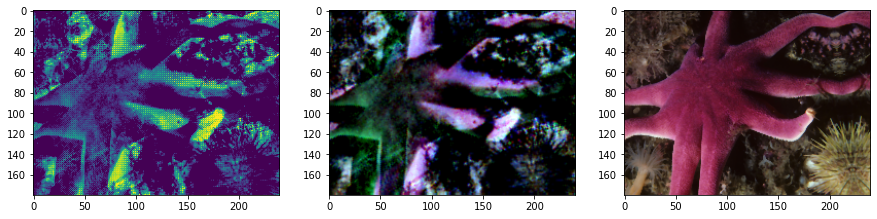

Warning, there are no events between two frames, skipping one.


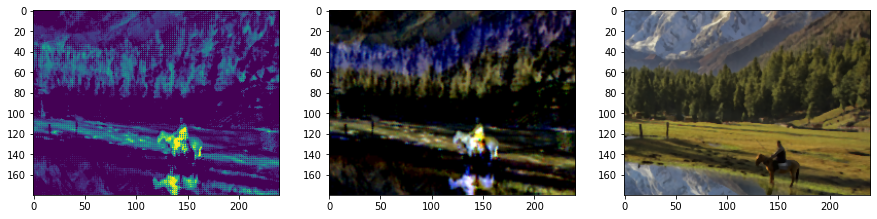

Warning, there are no events between two frames, skipping one.


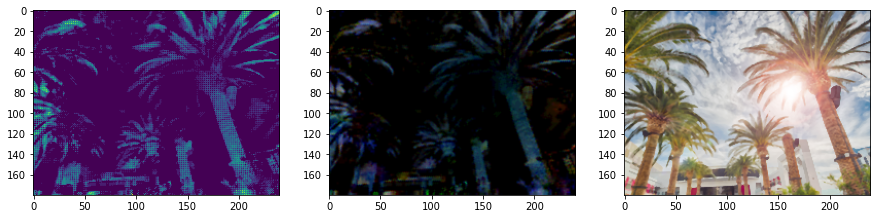

Warning, there are no events between two frames, skipping one.


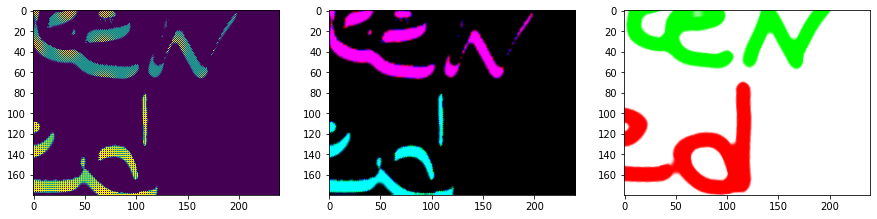

Warning, there are no events between two frames, skipping one.


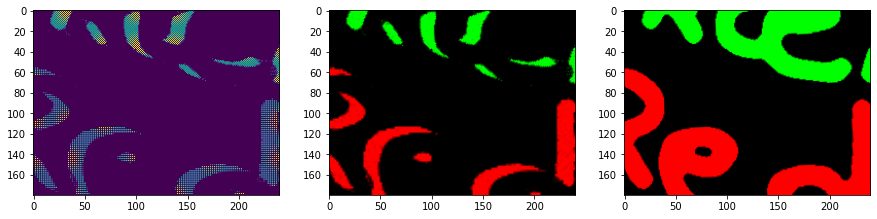

Warning, there are no events between two frames, skipping one.


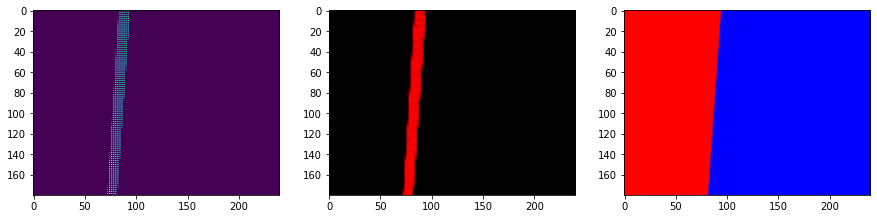

Warning, there are no events between two frames, skipping one.


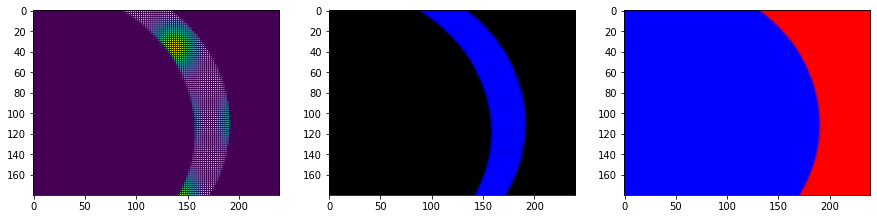

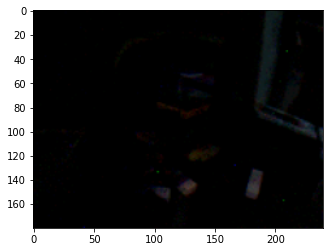

In [96]:
from dataset import DIV2KDataset, CEDDataset
from dataset_utils import dataset_generator_from_bag
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def demosaic_events_from_generator(gen, contrast_th=15, starting_brightness = 0, n=-1):
    for i, (events, img) in enumerate(gen):
        events_sum = starting_brightness + (np.sum(events, axis=0) * contrast_th)
        events_sum = events_sum.clip(0, 255).astype(np.uint8)
        demosaic = cv2.demosaicing(events_sum, cv2.COLOR_BAYER_RGGB2RGB)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(events_sum)
        axs[1].imshow(demosaic)
        axs[2].imshow(img)
        plt.show()

        if i == (n - 1):
            break

def quarter_colors_reconstruction_from_generator(gen, contrast_th=15, starting_brightness = 0, n=-1):   
    for i, (events, img) in enumerate(gen):
        events_sum = starting_brightness + (np.sum(events, axis=0) * contrast_th)
        events_sum = events_sum.clip(0, 255).astype(np.uint8)

        r = events_sum[0::2, 0::2]
        g = (events_sum[0::2, 1::2] + events_sum[1::2, 0::2]) // 2
        b = events_sum[1::2, 1::2]

        img = np.stack((r,g,b), axis=-1)
        img_up = cv2.resize(img, (120 * 2, 90 * 2))
        plt.imshow(img_up)
        plt.show()

        if i == (n - 1):
            break

# DIV2K_DATASET_PATH = r"C:\datasets\DIV2K_5_fix"
# div2k_gen = DIV2KDataset(DIV2K_DATASET_PATH, sequences=["0001"])

# CED_PATH = r"G:\VM\Shared Folder\simple_color_keyboard_2.bag"
# CED_PATH = r"G:\CED Datasets\simple_wires_1.bag"
CED_PATH = r"G:\CED Datasets\simple_jenga_1.bag"
# ced_gen = dataset_generator_from_bag(CED_PATH, "/dvs/events", "/dvs/image_color", min_n_events=500_000)

div2kpaths = [
    r"G:\VM\Shared Folder\0001.bag",
    r"G:\VM\Shared Folder\0002.bag",
    r"G:\VM\Shared Folder\0003.bag",
    r"G:\VM\Shared Folder\test_image.bag",
    r"G:\VM\Shared Folder\test_image_black.bag",
    r"G:\VM\Shared Folder\red_blue.bag",
    r"G:\VM\Shared Folder\blue_circle.bag",
]

for path in div2kpaths:
    gen = dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw")
    demosaic_events_from_generator(gen, n=1)

gen = dataset_generator_from_bag(CED_PATH, "/dvs/events", "/dvs/image_color", min_n_events=700_000)
quarter_colors_reconstruction_from_generator(gen, n=1)



## Representations for thesis

In [ ]:
import rosbag
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset_utils import dataset_generator_from_bag
path = r"G:\CED Datasets\simple_color_keyboard_2.bag"

# Event frame
image = np.zeros((260, 346))
with rosbag.Bag(path) as b:
    for topic, msg, timestamp in b.read_messages(topics=["/dvs/events"]):
        events = msg.events
        for event in events:
            if event.polarity:
                image[event.y, event.x] = 1
        break
plt.imsave("event_frame.png", image)

# Time surface
n_messages = 10
image = np.zeros((260, 346))
with rosbag.Bag(path) as b:
    messages = iter(b.read_messages(topics=["/dvs/events"]))
    for i in range(n_messages):
        topic, msg, timestamp = next(messages)
        events = msg.events
        for event in events:
            image[event.y, event.x] = event.ts.to_nsec()
                
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap="turbo")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.savefig("time_surface.png")

# 3D Point Cloud
n_events = 10000
xs = []
ys = []
ts = []
colors = []
with rosbag.Bag(path) as b:
    messages = b.read_messages(topics=["/dvs/events"])
    i = 0
    for topic, msg, timestamp in messages:
        events = msg.events
        for event in events:
            xs.append(event.x)
            ys.append(event.y)
            ts.append(event.ts.to_nsec())
            color = "red" if event.polarity else "blue"
            colors.append(color)
            i += 1
        
            if i == n_events:
                break
        if i == n_events:
            break
ts = np.array(ts)
ts = (ts - ts.min()) / (ts.max() - ts.min())

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xs, ys, ts, c=colors, s=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('ts')
ax.view_init(40, 0)
plt.xlim(max(plt.xlim()), min(plt.xlim()))

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xs, ys, ts, c=colors, s=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('ts')
ax.view_init(88, 90)
plt.xlim(max(plt.xlim()), min(plt.xlim()))

plt.tight_layout()
plt.savefig("3d_point_cloud.png")

# Voxel Grid
for events, img in dataset_generator_from_bag(path):
    for i, bin_ in enumerate(events):
        plt.imsave(f"bin_{i}.png", bin_)
    break

# DIV2K Examples
base_path = r"G:\VM\Shared Folder\bags\DIV2K_0.5"
bags = [
    "0001.bag",
    "0015.bag",
    "0075.bag",
]
for bag in bags:
    path = os.path.join(base_path, bag)
    gen = iter(dataset_generator_from_bag(path, "/cam0/events", "/cam0/image_raw", crop_size=(128, 128)))
    for i in range(20):
        if i % 6 == 0:
            events, img = next(gen)
            name = bag.replace(".bag", "")
            plt.imsave(f"{name}_bin_{i}.png", events[4], cmap="gray")
            plt.imsave(f"{name}_img_{i}.png", img)